In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [122]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X_train = train.drop(['No-show'], axis=1).values
y_train = train['No-show'].values
X_test = test.drop(['No-show'], axis=1).values
y_test = test['No-show'].values

In [123]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [124]:
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

In [125]:
class NoShowPredictor(nn.Module):
    def __init__(self, input_size):
        super(NoShowPredictor, self).__init__()
        self.layer1 = nn.Linear(input_size, 8)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(8, 16)
        self.activation2 = nn.ReLU()
        self.layer3 = nn.Linear(16, 2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        x = self.activation2(x)
        x = self.layer3(x)
        x = self.softmax(x)
        return x

In [126]:
input_size = X_train.shape[1]
model = NoShowPredictor(input_size)
Loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [128]:
epochs = 1000
losses = []
f1_scores = []

for epoch in range(epochs):
    output = model(X_train)
    loss = Loss(output, y_train)    
    _, predicted = torch.max(output.data, 1)
    f1 = f1_score(y_train.numpy(), predicted.numpy(), average='macro')    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    
    losses.append(loss.item())
    f1_scores.append(f1)    
    if epoch % 100 == 0 or epoch == epochs - 1:
        print(f'Epoch {epoch}: loss={loss.item():.4f}, F1 score={f1:.4f}')

Epoch 0: loss=0.6970, F1 score=0.3333
Epoch 100: loss=0.6315, F1 score=0.6524
Epoch 200: loss=0.6119, F1 score=0.6599
Epoch 300: loss=0.6101, F1 score=0.6625
Epoch 400: loss=0.6095, F1 score=0.6639
Epoch 500: loss=0.6091, F1 score=0.6642
Epoch 600: loss=0.6088, F1 score=0.6652
Epoch 700: loss=0.6086, F1 score=0.6654
Epoch 800: loss=0.6084, F1 score=0.6651
Epoch 900: loss=0.6083, F1 score=0.6662
Epoch 999: loss=0.6082, F1 score=0.6661


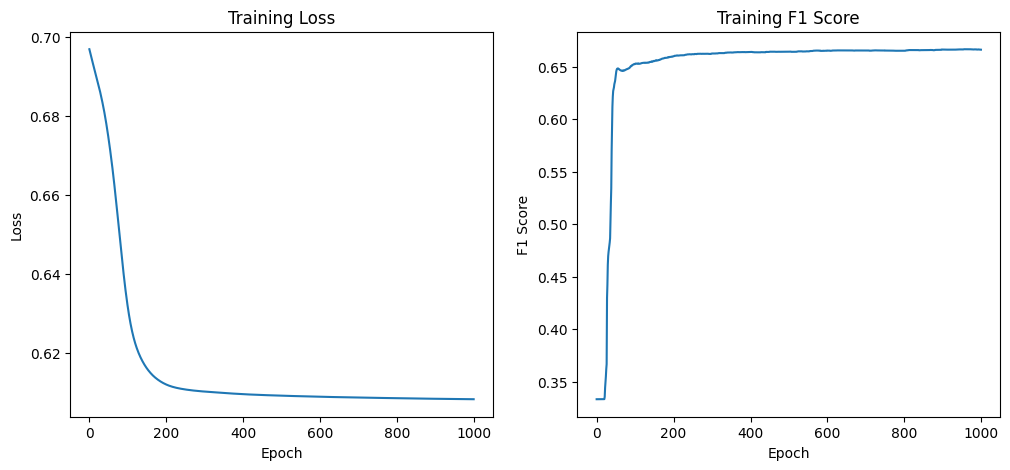

In [129]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(f1_scores)
plt.title('Training F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.show()

In [130]:
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs.data, 1)
    y_pred = test_predicted.numpy()
    y_probs = test_outputs.numpy()[:, 1]
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC: {pr_auc:.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.52      0.61     17642
           1       0.63      0.83      0.72     17642

    accuracy                           0.67     35284
   macro avg       0.69      0.67      0.67     35284
weighted avg       0.69      0.67      0.67     35284

Confusion Matrix:
 [[ 9125  8517]
 [ 3006 14636]]
PR-AUC: 0.6815


<Figure size 1200x500 with 0 Axes>

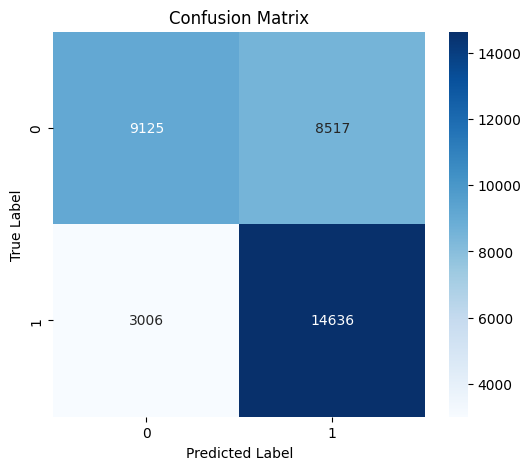

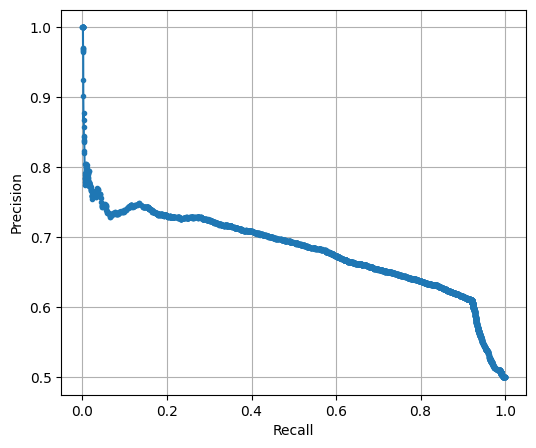

In [131]:
plt.figure(figsize=(12,5))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize=(6,5))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()